# DVD Inversion exercise (GNSS- Low Noise)

This is the noteboook that solves the inversion exercise using just GNSS dataset

## Import libraries

In [1]:
%matplotlib inline
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib
import h5py
from vmod import util
from vmod.data import Gnss
from vmod.source import Mctigue
from vmod.inverse import Inverse

## Read dataset

In [2]:
csvfile='examples/dvd/gps/Synth_ENU_Low_Gaussian.csv'
xs,ys,uxs,uys,uzs=np.loadtxt(csvfile,skiprows=1,delimiter=',',unpack=True)
euxs=xs*0+1e-3
euys=np.copy(euxs)
euzs=np.copy(euxs)
names=[str(i).zfill(4) for i in range(len(xs))]

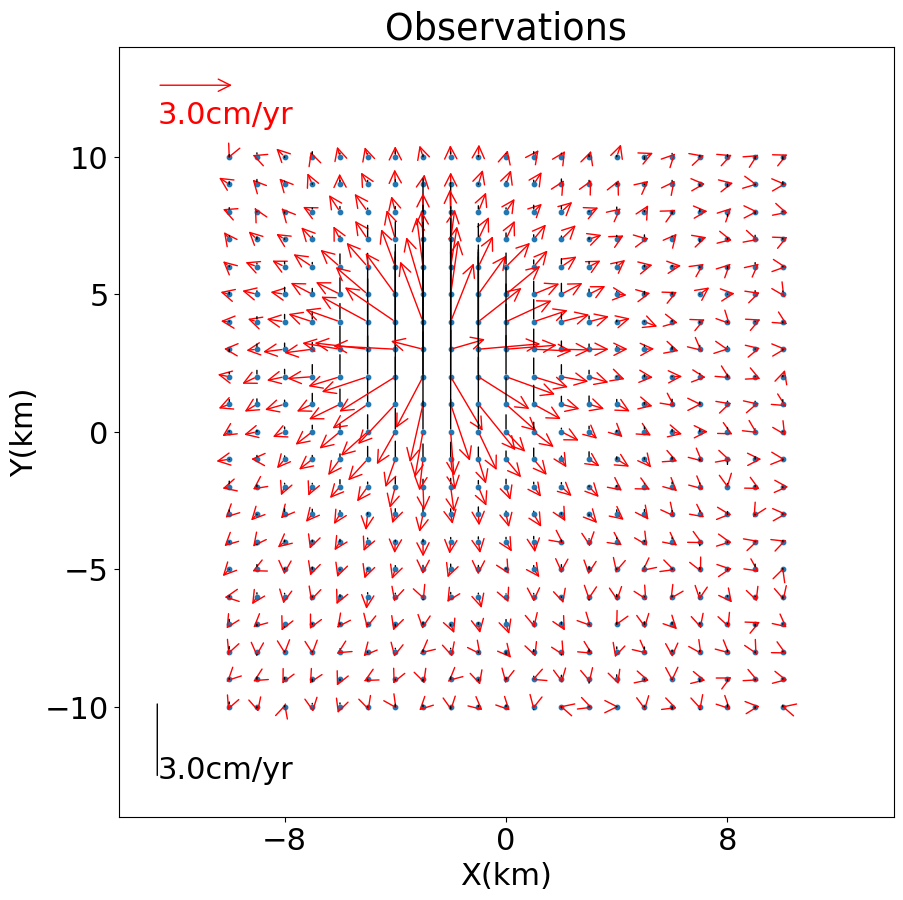

In [3]:
plt.rcParams.update({'font.size': 22})
util.plot_gnss(xs,ys,uxs,uys,uzs,title='Observations',scl=3.0,figsize=(10,10))

## Create data object

In [4]:
obs=Gnss()

obs.add_names(names)

obs.add_xs(xs)
obs.add_ys(ys)

obs.add_ux(uxs)
obs.add_uy(uys)
obs.add_uz(uzs)

obs.add_errx(euxs)
obs.add_erry(euys)
obs.add_errz(euzs)

#obs.importcsv('examples/gps/fisher_gnss.txt')

## Create Model object

In [5]:
mct = Mctigue(obs)
uxsm,uysm,uzsm=mct.forward([0,0,2.0e3,5e2,0.003],unravel=False)

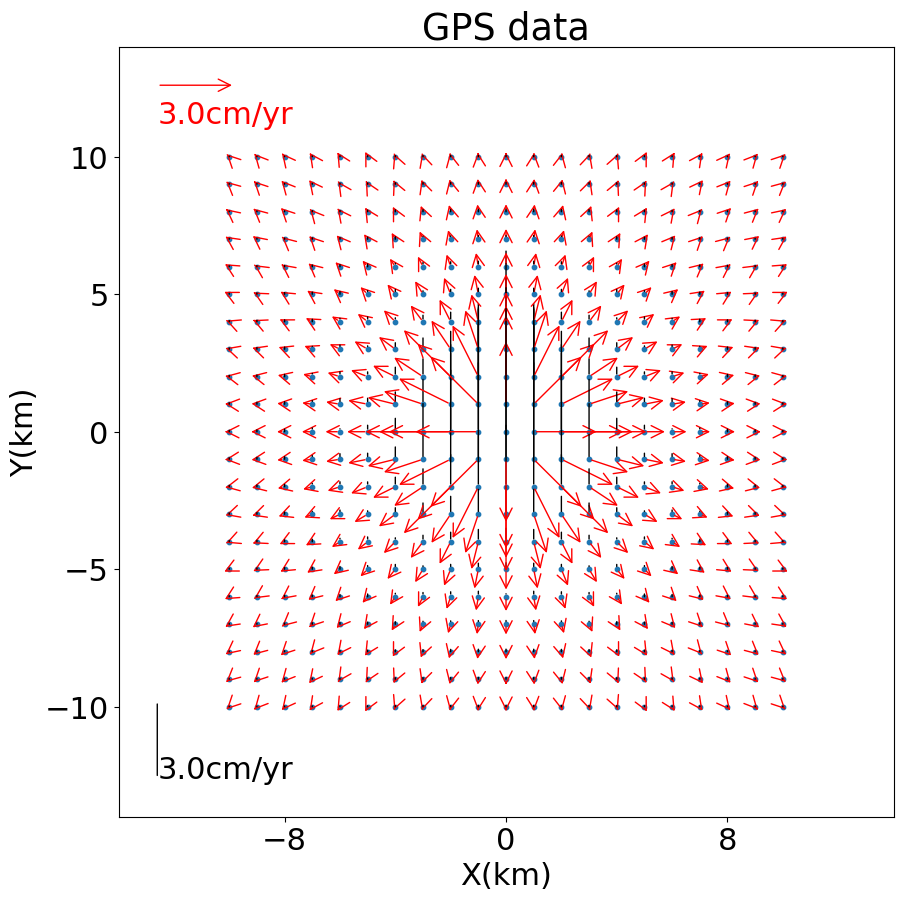

In [6]:
util.plot_gnss(xs,ys,uxsm,uysm,uzsm,scl=3.0,figsize=(10,10))

## Create Inversion object

In [7]:
mct.set_x0([0,0,2.0e3,5e2,0.003])
#Bounds for parameters
mct.set_bounds(low_bounds = [-10000,-10000,5e2,1e1,0.0001], high_bounds = [10000,10000,1e4,5e3,0.01])

inv=Inverse(obs)
inv.register_source(mct)

## Least-squares Inversion

In [9]:
ans=inv.nlsq()

parnames,orders=inv.get_parnames_orders()
for i,parname in enumerate(parnames):
    print(parname,ans.x[i])

36.363289501686836
xcen -2517.0480098184844
ycen 2872.8670855550176
depth 2184.460597627537
radius 1014.5195344235946
dP 0.0003883634860800938


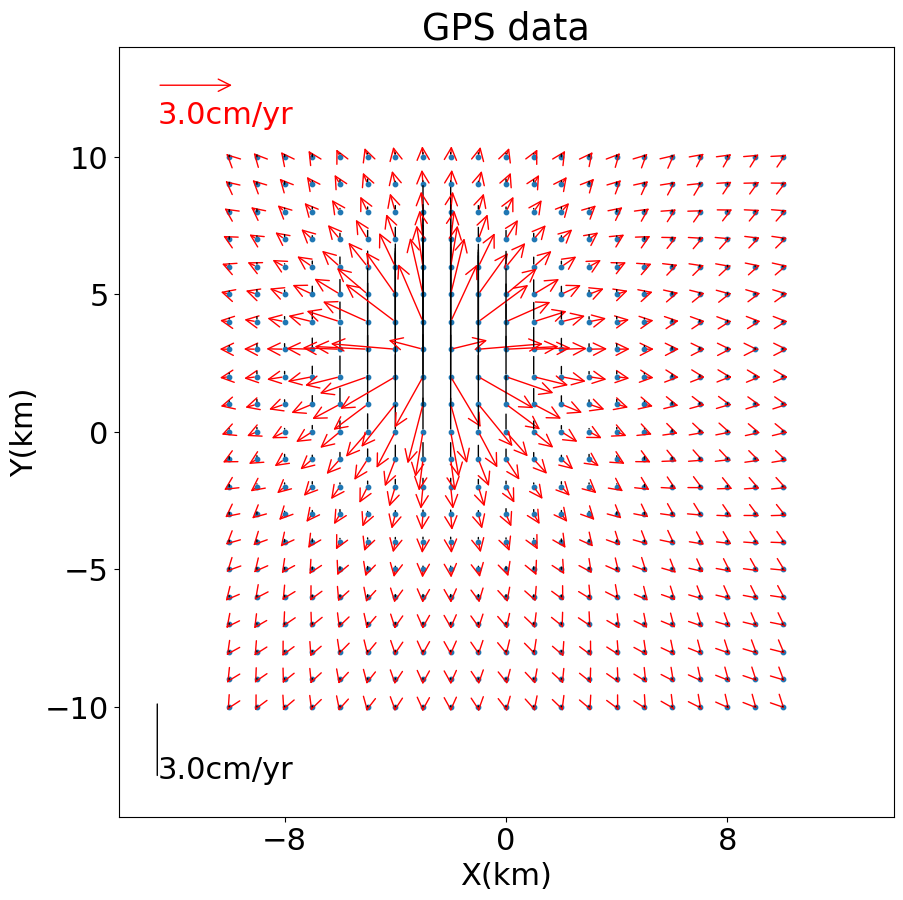

In [11]:
uxsm,uysm,uzsm=mct.forward(ans.x,unravel=False)

util.plot_gnss(xs,ys,uxsm,uysm,uzsm,scl=3.0,figsize=(10,10))

In [13]:
import pickle
with open('gnss_low_emcee.pkl', 'rb') as f:
    data = pickle.load(f)

trace=[]
for key in data.keys():
    trace.append(data[key])

## Bayesian Inversion

In [11]:
trace=inv.mcmc_em('gnss_low_emcee')

[0.0, 0.0, 2.0, 5.0, 3.0, 0.0]


100%|████████████████████████████████████████████████████████████████████████████| 91666/91666 [33:20<00:00, 45.83it/s]


In [20]:
traces=np.copy(trace)
np.save('traces.npy',traces)
data=traces

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
C:\Users\elfer\AppData\Local\Temp\ipykernel_21132\1526849072.py:9: SyntaxWarning: invalid escape sequence '\m'
  labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$','D(km)','R(km)','$P(\mu)$']


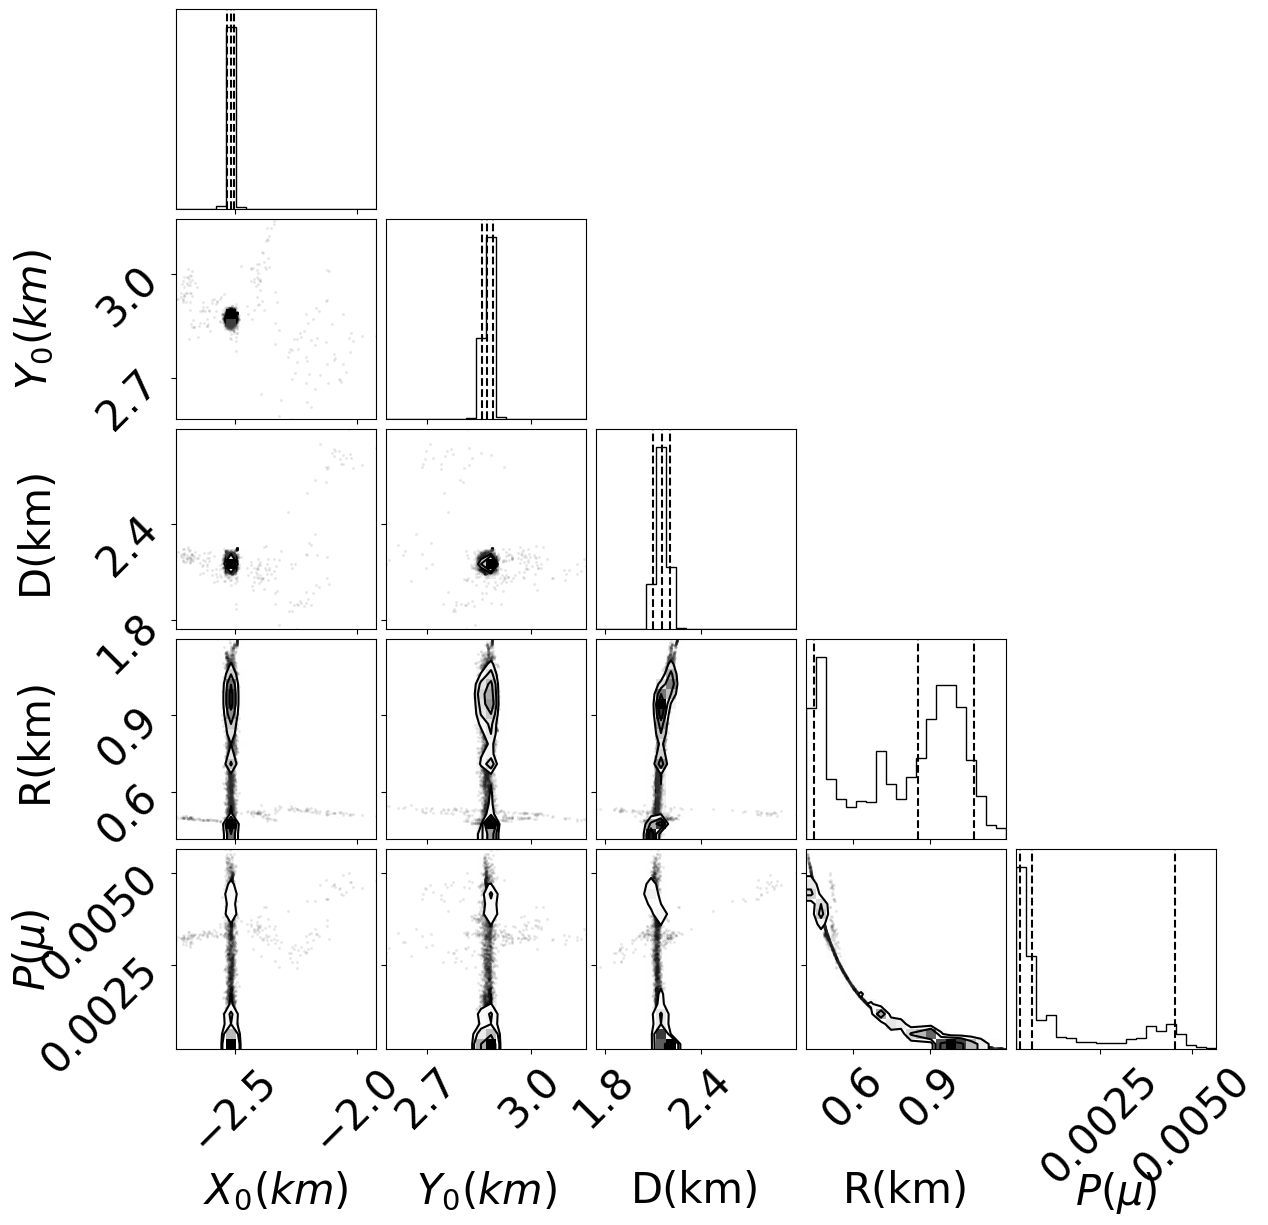

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

data[0,:]=data[0,:]/1e3
data[1,:]=data[1,:]/1e3
data[2,:]=data[2,:]/1e3
data[3,:]=data[3,:]/1e3
data[4,:]=data[4,:]
labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$','D(km)','R(km)','$P(\mu)$']

plt.rcParams.update({'font.size': 30})
figure = corner.corner(data.T, labels=labels,
                       quantiles=[0.05, 0.5, 0.95],max_n_ticks=2,labelpad=0.3,
                       show_titles=False, label_kwargs={"fontsize": 30}, title_kwargs={"fontsize": 30})

## Forward model for the median solution

[-2.51585515e+03  2.87420274e+03  2.15390354e+03  8.52132487e+02
  6.58364952e-04]


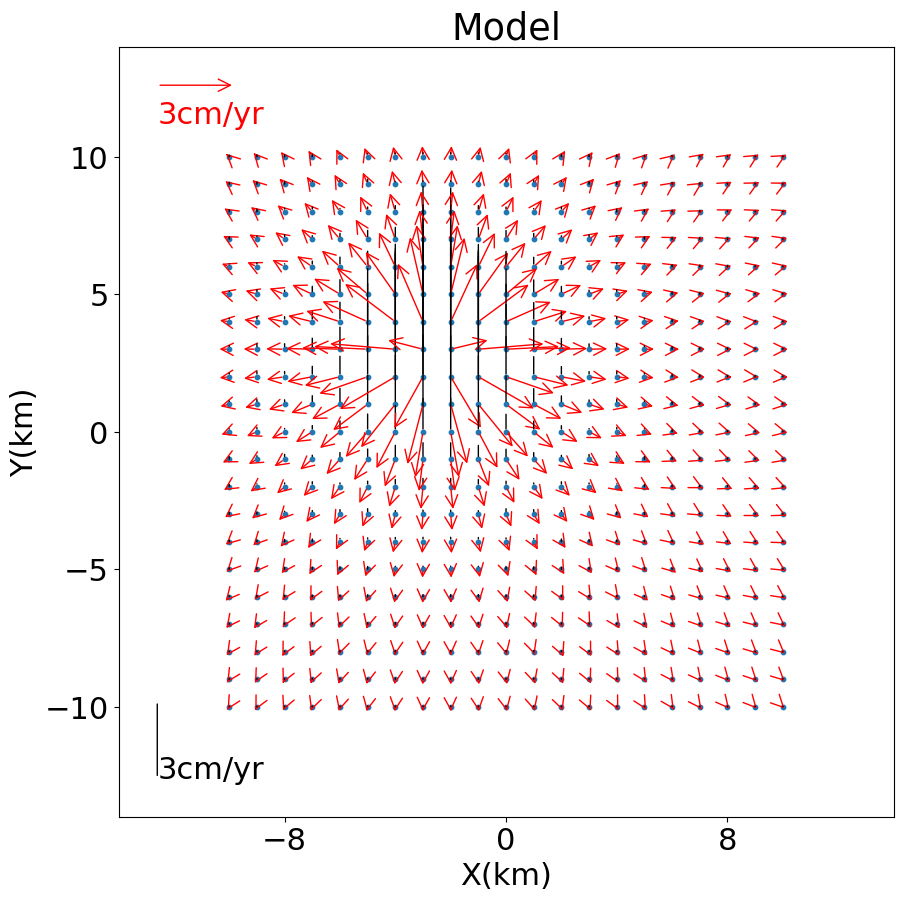

In [22]:
xbest=np.array([np.median(data[0,:])*1e3,np.median(data[1,:])*1e3,np.median(data[2,:])*1e3,np.median(data[3,:])*1e3,np.median(data[4,:])])
print(xbest)
uxsm,uysm,uzsm=mct.forward(xbest,unravel=False)
plt.rcParams.update({'font.size': 22})
util.plot_gnss(xs,ys,uxsm,uysm,uzsm,title='Model',scl=3,figsize=(10,10))

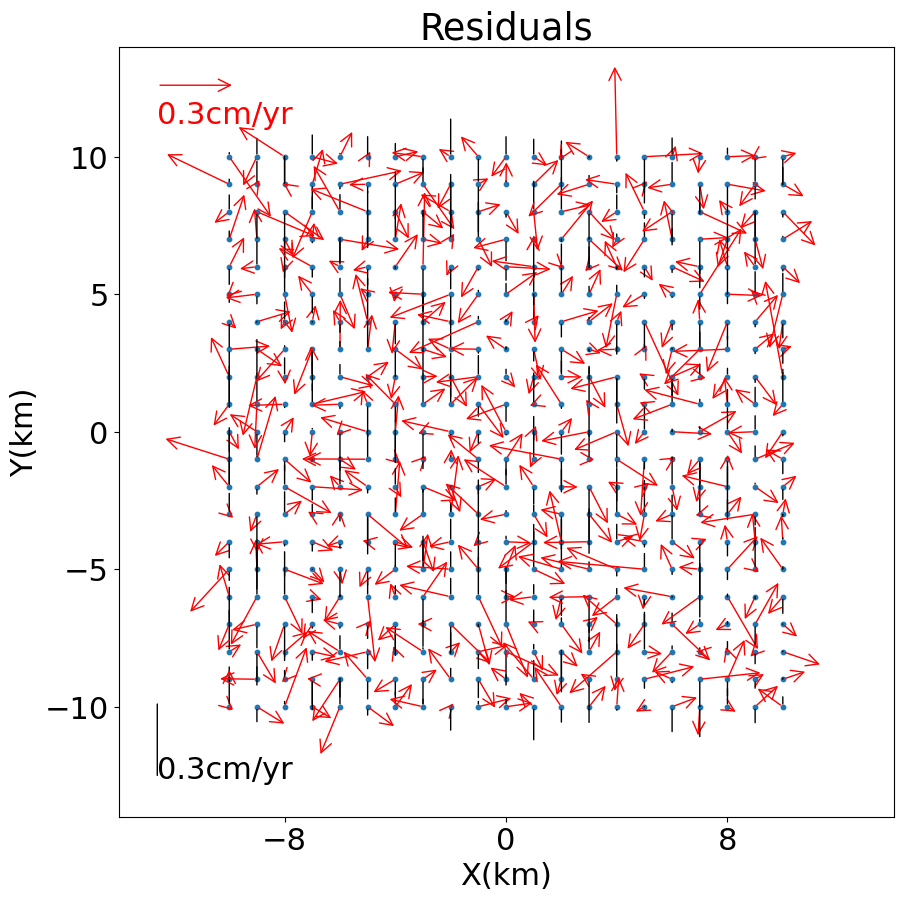

In [23]:
util.plot_gnss(xs,ys,uxs-uxsm,uys-uysm,uzs-uzsm,title='Residuals',scl=0.3,figsize=(10,10))